# pyxem


### A 4-D STEM Package in the Hyperspy Ecosystem

#### Carter Francis, University of Wisconsin Madison
#### *June 13, 2023*

# Outline

1. Introduction to 4D STEM
2. Introduction to pyxem
3. Example Workflows
    1. Loading and Visualizing Data
    2. Creating Virtual Images (MgO Nanocrystals)
    3. Finding Diffraction Vectors and Crystal Segmentation (MgO Nanocrystals)
    4. Orientation Mapping (MgO Nanocrystals)
    5. Strain Mapping (Inclusions in ZrNb)(**Not Covered:** Go to https://github.com/CSSFrancis/PyxemIUMAS/blob/master/Extras/Strain%20Mapping.ipynb)
    6. Electrical and Magnetic DPC (**Not Covered:** Go to https://github.com/pyxem/pyxem-demos)
    7. Orientation Mapping for Molecular Glasses ((**Not Covered:** Go to https://github.com/CSSFrancis/PyxemIUMAS/blob/master/Extras/12%20MolecularGlassOrientationMapping.ipynb)
    7. Strcutural Characterization of Metallic Glasses (**Not Covered:** Come to my talk later this week!)
4. Lazy Workflows and Scaling to Large Datasets

# 1. Introduction to 4D STEM

<img src="Images/4DSTEM.gif" alt="4D STEM GIF">

# 2. Introduction to pyxem (pix-em)


Because pyxem extends hyperspy importing hyperspy will automatically load pyxem if it is installed.

This also means that we inherit all of the upstream hyperspy functionality such as:

1. Fast I-O (from [many different file formats](https://hyperspy.org/rosettasciio/supported_formats/index.html))
2. Machine learning with [Matrix Factorization](https://hyperspy.org/hyperspy-doc/current/user_guide/mva.html)
3. Fitting with [1-D and 2-D functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html)
4. [Interactive Plotting](https://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html)
5. [Metadata Handling](https://hyperspy.org/hyperspy-doc/current/user_guide/metadata_structure.html)
6. And __Much Much__ More!

For more information about pyxem check out our [github](https://github.com/pyxem/pyxem) our [documentation](https://pyxem.readthedocs.io/en/latest/) or the set of [tutorial notebooks](https://github.com/pyxem/pyxem-demos) 

In [1]:
#import zarr

In [2]:
#s = zarr.ZipStore("data/mgo_nano.zspy")

In [3]:
# Let's start by importing hyperspy
import hyperspy.api as hs
hs.set_log_level("ERROR") # Setting the logging level to "ERROR" to silence "WARNINGS"
# print the known signal types
#hs.print_known_signal_types() 

# 3. Examples 

## 3.1 Loading and Visualizing Data

Data in `pyxem` can be loaded exactly the same as loading data in `hyperspy`.  Many different formats are supported but only the `.hspy` (hdf5) and `.zspy` (zarr) formats retain all of the metadata

```python
import hyperspy.api as hs
s = hs.load("path/to/file/to/load.hspy")
```

Visualization can easily be done by then calling the function

```python
s.plot()
```


In [4]:
# Starting up a distributed Cluster locally 
# You don't have to do this but it helps to visualize what is happening
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
# Ignore INFO below just giving informataion about the scheduler set up

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/zs/ggjk5_sn2yjgjq4_l93t8__r0000gn/T/dask-scratch-space/scheduler-ltyvvda3', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:49520
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49523'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49524'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49525'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49526'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:49540', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:49540
INFO:distrib

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49520,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:49532,Total threads: 2
Dashboard: http://127.0.0.1:49534/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49523,


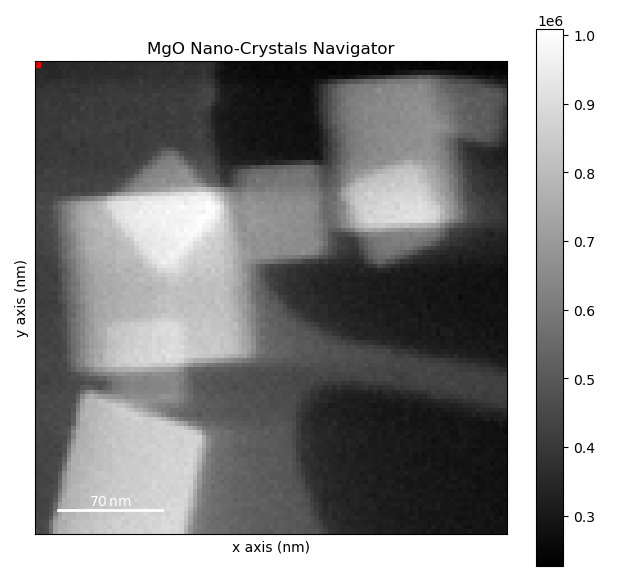

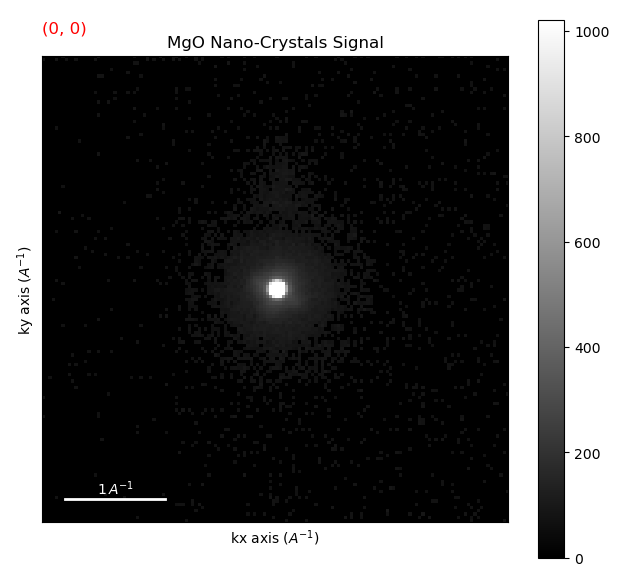

In [5]:
# setting the plotting backend
%matplotlib widget
dp = hs.load("data/mgo_nanoparticles.zspy", lazy=True) # Use Zarr backend for speed and load data lazily 
dp.plot() # plot the signal DP

## 3.2 Creating Virtual Images
We can construct Virtual images very easily using [ROIS](http://hyperspy.org/hyperspy-doc/current/user_guide/interactive_operations_ROIs.html) from `hyperspy`.

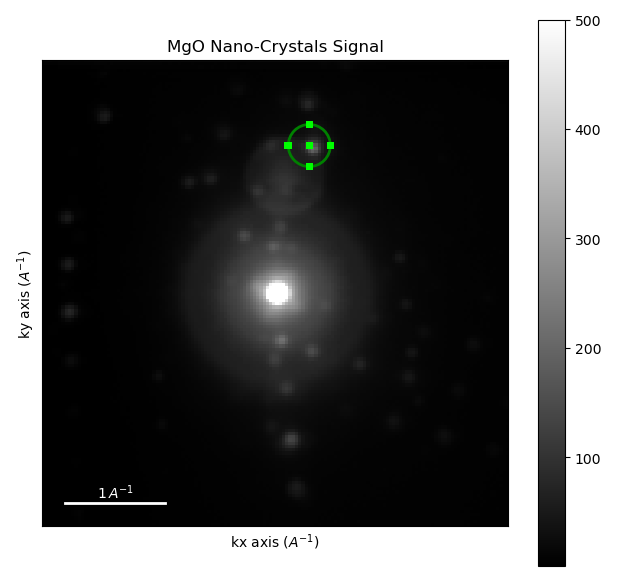

In [6]:
mean_cbed = dp.mean() # get the mean diffraction pattern
mean_cbed.plot(vmax=500) # plot the mean diffraction pattern
roi = hs.roi.CircleROI(cx=0.3246, cy=-1.49316, r= 0.2) # create a ROI to be used as a virtual appature
roi.add_widget(mean_cbed) # add roi to plot

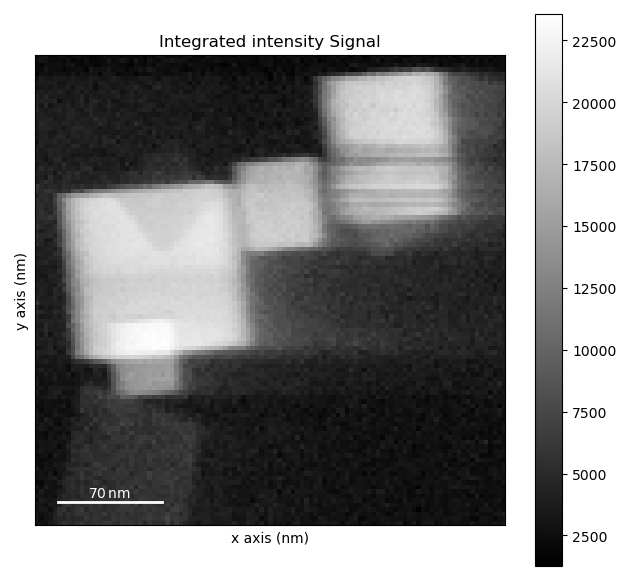

In [7]:
virtual = dp.get_integrated_intensity(roi) # integrate the ROI
virtual.plot()

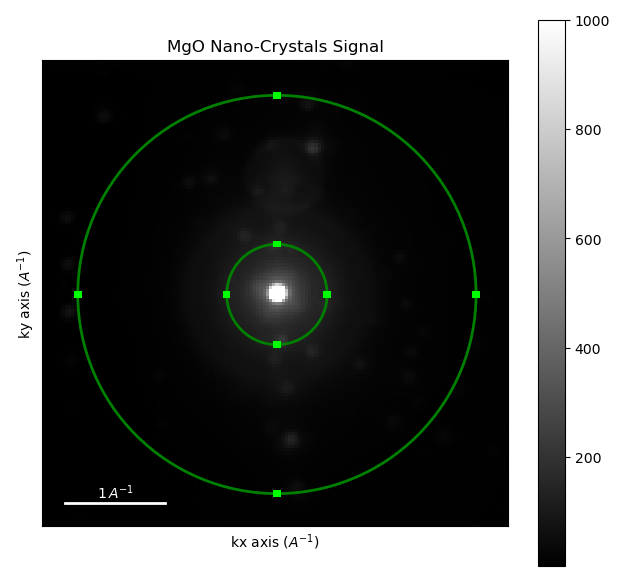

In [8]:
mean_cbed = dp.mean() # get the mean diffraction pattern
mean_cbed.plot(vmax=1000) # plot the mean diffraction pattern
df_roi = hs.roi.CircleROI(cx=0, cy=0, r= 2.0, r_inner=0.5) # create a ROI to be used as a virtual appature
df_roi.add_widget(mean_cbed) # add roi to plot

[<Axes: title={'center': 'Virtual Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Virtual Aperture'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

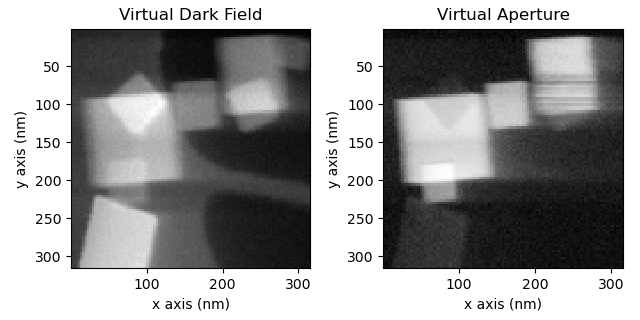

In [9]:
df =  dp.get_integrated_intensity(df_roi) # integrate the DF ROI 
hs.plot.plot_images([df, virtual], label=["Virtual Dark Field", "Virtual Aperture"], tight_layout=True, colorbar=None) # Plot both ROI's using hyperspy

## 3.3 Finding Diffraction Vectors and Crystal Segmentation

For many operations in `pyxem` such as Crystal Segmentation, Strain Mapping and Clustering we start with finding the set of diffraction vectors within the dataset.  This starts with the function `s.find_peaks()` which we can use both interactively and non-interactively.

Examples of Crystal Segmentation from Tina Bergh:

<center><img src="Images/NanocrystalSegmentation.png" alt="4D STEM GIF" height="1000" width="1000"></center>


```
BERGH, T., JOHNSTONE, D.N., CROUT, P., HØGÅS, S., MIDGLEY, P.A., HOLMESTAD, R., VULLUM, P.E. and HELVOORT, A.T.J.V. (2020), Nanocrystal segmentation in scanning precession electron diffraction data. Journal of Microscopy, 279: 158-167. https://doi.org/10.1111/jmi.12850
```

In this case watershed segmentation from found peaks is shown but additional workflows using NNMF are also available.

##### Removing Background

In [10]:
dp_sub = dp.subtract_diffraction_background(method="difference of gaussians", min_sigma=4, max_sigma=8)

##### Finding Diffraction Vectors

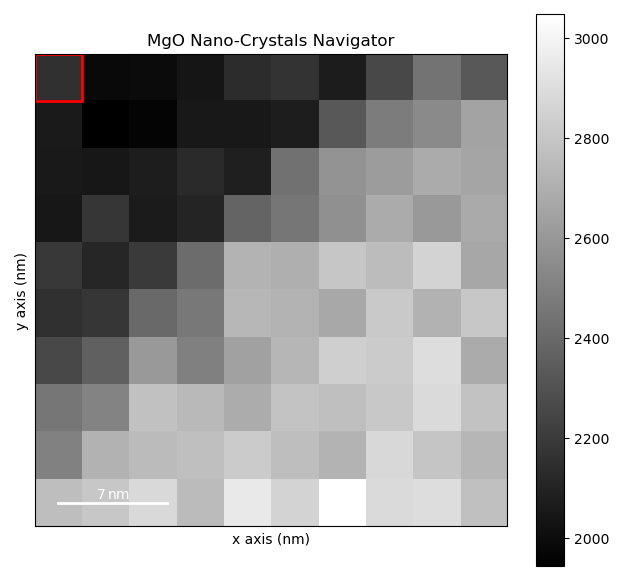

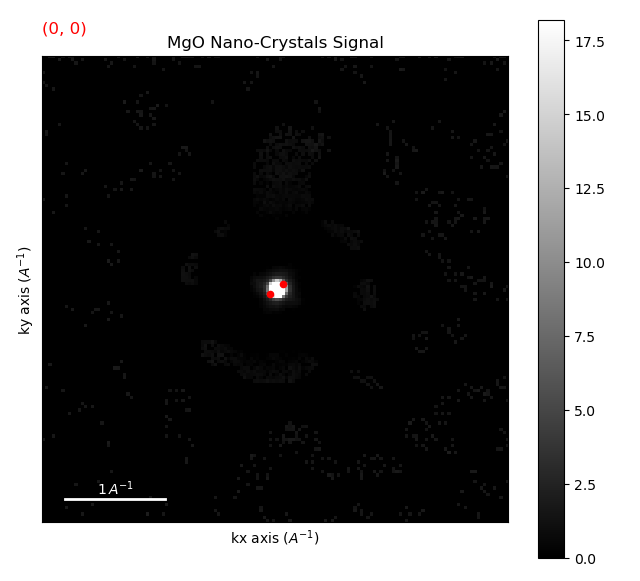

In [11]:
import numpy as np
dp_sliced = dp_sub.inav[20:30,20:30] # slice that data to make the interactive processing work better
slic_max = np.max(dp_sliced.data) # find max of the data for scaling
dp_sliced = dp_sliced/slic_max * 20 # scale the data for interactive find_peaks
pks = dp_sliced.find_peaks(method="local_max",
                           threshold_abs=10, 
                           min_distance=3,vmax=10) # find peaks interactively 

In [12]:
dp

<LazyElectronDiffraction2D, title: MgO Nano-Crystals, dimensions: (105, 105|144, 144)>

In [13]:
# Convert to diffraction vectors (This workflow will be simplified once pyxem 1.0.0 is released!)
from pyxem.signals import DiffractionVectors
import numpy as np
pks = dp_sub.find_peaks(interactive=False, 
                    method="local_max",
                    threshold_abs=2.2*slic_max/20,
                    min_distance=3) # Finding peaks on the entire dataset
dv = DiffractionVectors.from_peaks(peaks=pks,
                                   center=np.array(dp.axes_manager.signal_shape)/2-.5,
                                   calibration=dp.axes_manager.signal_axes[0].scale) # convert to Diffraction Vectors Signal

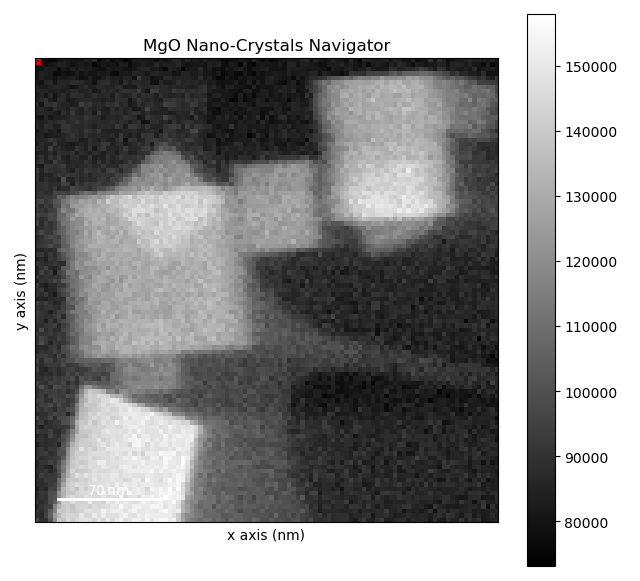

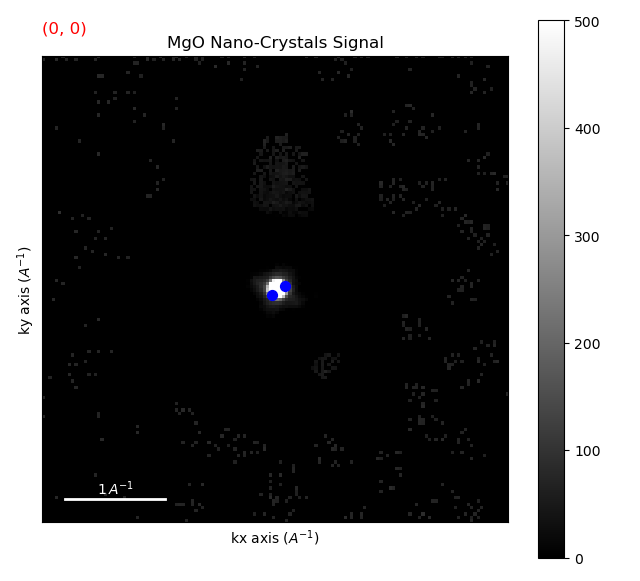

In [14]:
%matplotlib widget
from pyxem.signals.diffraction_vectors import generate_marker_inputs_from_peaks
xx,yy = generate_marker_inputs_from_peaks(dv) # generating hyperspy markers from peaks
dp_sub.plot(vmax=500)
for x,y in zip(xx,yy):
    m = hs.plot.markers.point(y,x,
                              color="blue",
                              size=50,)
    dp_sub.add_marker(m, plot_marker=True, permanent=False,)

##### Plotting Diffraction Vectors

In [15]:
import matplotlib.pyplot as plt
plt.close("all")

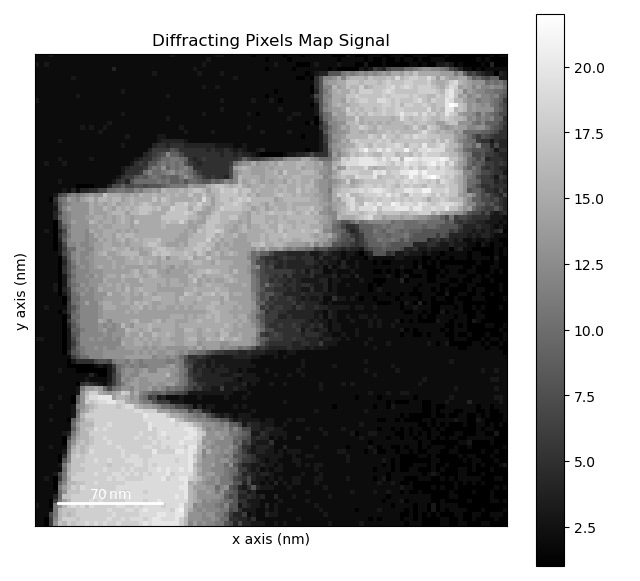

In [16]:
# plot the map (number found) of diffraction vectors 
dv.get_diffracting_pixels_map().plot()

In [17]:
distance_threshold = 0.1
min_samples = 7
# cluster the vectors to get only the unique vectors
unique_peaks = dv.get_unique_vectors(method='DBSCAN',
                                     distance_threshold=distance_threshold,
                                     min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

#remove the zero beam
unique_peaks = unique_peaks.filter_magnitude(min_magnitude=.4,
                                   max_magnitude=np.inf) 
print(np.shape(unique_peaks)[0], ' unique vectors.')

59  unique vectors were found.
58  unique vectors.


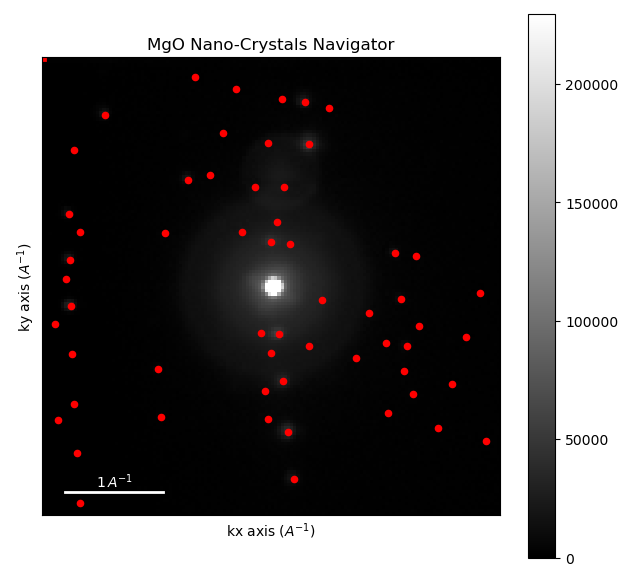

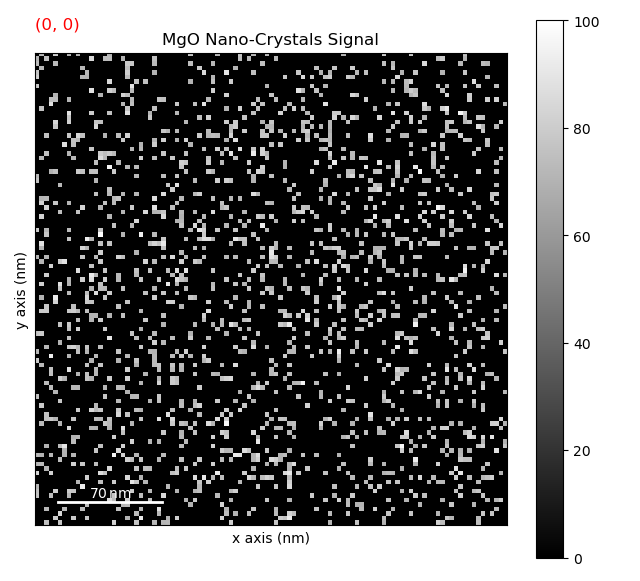

In [18]:
%matplotlib widget
dpt = dp.T
dpt.plot()
for x,y in zip(unique_peaks.data[:,1],unique_peaks.data[:,0]):
    markers = hs.plot.markers.point(x= x,y=y, color="r")
    dpt.add_marker(markers, plot_on_signal=False)

##### Creating Virtual Images

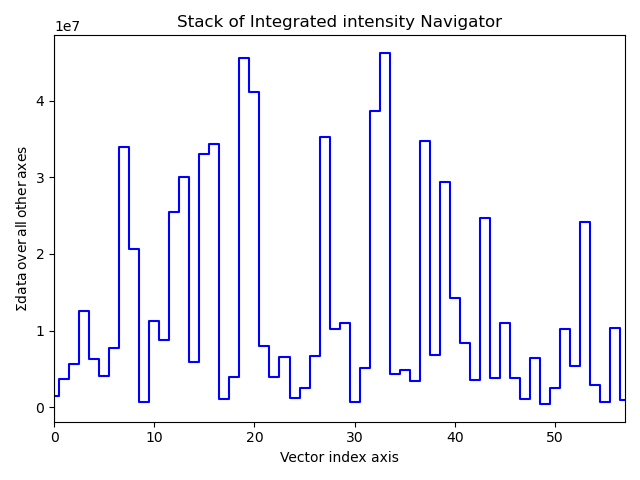

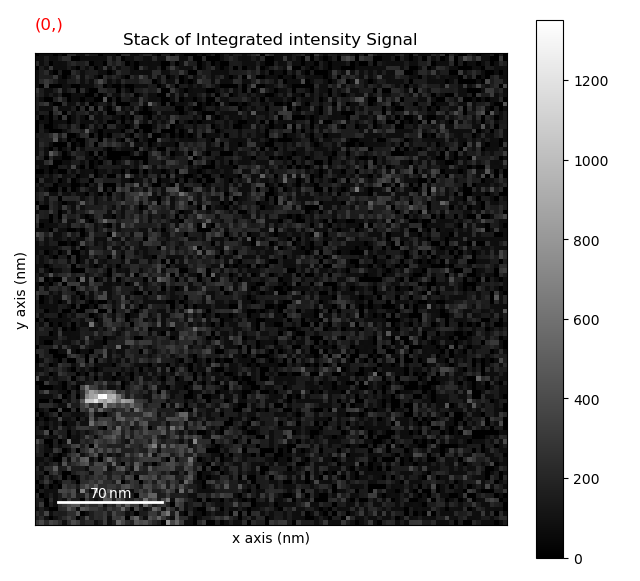

In [19]:
from pyxem.generators import VirtualDarkFieldGenerator
radius=0.1
vdfgen = VirtualDarkFieldGenerator(dp, unique_peaks) # generate the virtual darkfield images
VDFs = vdfgen.get_virtual_dark_field_images(radius=radius) # create Dark Field images using the virtual appatures
VDFs.compute() # compute it and load into RAM
VDFs.plot() # plot the VDFS

In [20]:
min_distance = 10.5 # min distance in pixels between seed points
min_size = 30 # min size in pixels 
max_size = 10000 # max size in pixels
max_number_of_grains = 2000 #
marker_radius = 2 # plotting size of marker
exclude_border = 2 # exclude pixels near border
threshold= 0.5 # threshold for mask (as percent of max)

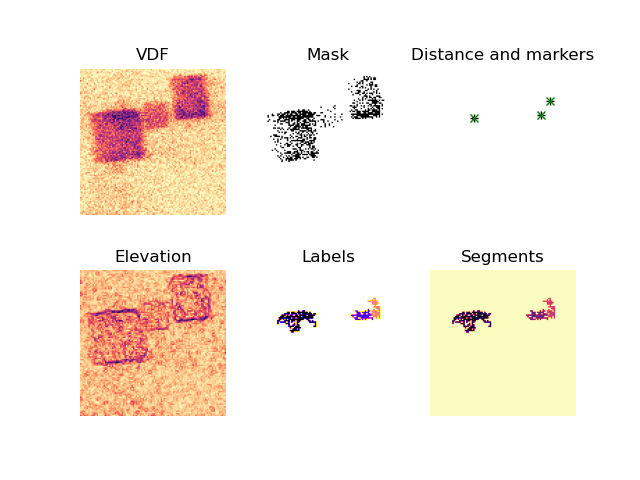

In [21]:
# test for the right watershed parameters
from pyxem.utils.segment_utils import separate_watershed
i = 50
sep_i = separate_watershed(
    VDFs.inav[i].data, min_distance=min_distance, min_size=min_size,
    max_size=max_size, max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, marker_radius=marker_radius,
    threshold=threshold, plot_on=True)

In [22]:
segs = VDFs.get_vdf_segments(min_distance=min_distance,
                             min_size=min_size,
                             max_size = max_size,
                             max_number_of_grains = max_number_of_grains,
                             exclude_border=exclude_border,
                             marker_radius=marker_radius,
                             threshold=threshold)

/Users/carterfrancis/PycharmProjects/pyxem/pyxem/signals/virtual_dark_field_image.py:110: UserWarning: Changed in version 0.15.0.  May cause unexpectederrors related to managing the proper axes.
  warnings.warn(


In [23]:
corr_threshold=0.4
vector_threshold=4
segment_threshold=3

In [24]:
corrsegs = segs.correlate_vdf_segments(
    corr_threshold=corr_threshold, vector_threshold=vector_threshold,
    segment_threshold=segment_threshold)
print(np.shape(corrsegs.segments)[0],' correlated segments were found.')
num_segments = np.shape(corrsegs.segments)[0]

  0%|                                                   | 0/127 [00:00<?, ?it/s]

7  correlated segments were found.


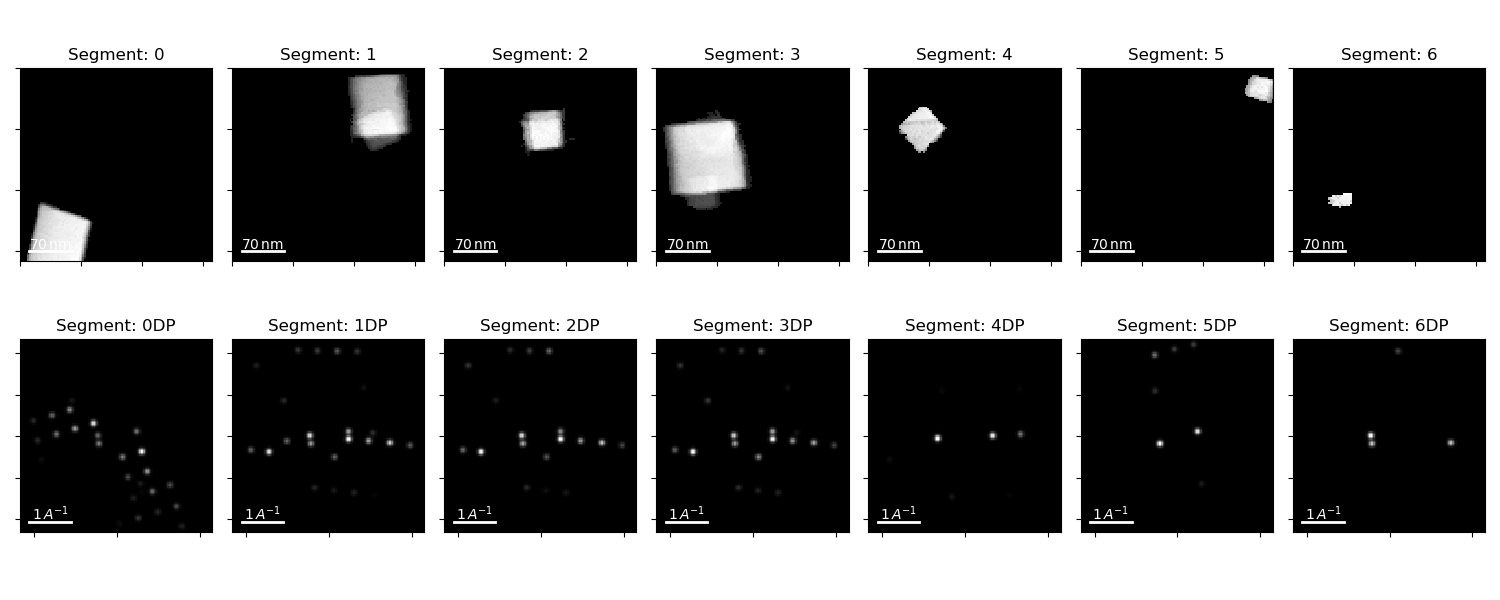

In [25]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,6))
virt_diff = corrsegs.get_virtual_electron_diffraction(calibration=dp.axes_manager.signal_axes[0].scale, shape=(144,144), sigma=.05)
virt_diff.set_diffraction_calibration(dp.axes_manager.signal_axes[0].scale)
segments = corrsegs.segments
labels = ["Segment: " + str(i) for i in range(num_segments)] + ["Segment: " + str(i) +"DP" for i in range(num_segments)] # For adding labels
hs.plot.plot_images(segments.split()+virt_diff.split(),
                    per_row=num_segments,
                    fig=f,tight_layout=True,
                    colorbar=None,
                    scalebar="all",
                    axes_decor=None,
                    label =labels) # adjust this function to get nice quality plotting in hyperspy
plt.show()

### 3.D Orientation Mapping

Orientation Mapping in `pyxem` is very fast and powerful!  There are many tools for aligning your data like:

- Aligning your zero beam with [center_direct_beam](https://pyxem.readthedocs.io/en/stable/reference.html#pyxem.signals.Diffraction2D.center_direct_beam)
- Removing astigmatism with  [apply_affine_transformation](https://pyxem.readthedocs.io/en/stable/reference.html#pyxem.signals.Diffraction2D.apply_affine_transformation)
- Removing the background as we did above using [subtract_background](https://pyxem.readthedocs.io/en/stable/reference.html#pyxem.signals.Diffraction2D.subtract_diffraction_background)

For more information see this paper:

```
Niels Cautaerts, Phillip Crout, Håkon W. Ånes, Eric Prestat, Jiwon Jeong, Gerhard Dehm, Christian H. Liebscher,
Free, flexible and fast: Orientation mapping using the multi-core and GPU-accelerated template matching capabilities in the Python-based open source 4D-STEM analysis toolbox Pyxem,
Ultramicroscopy,
Volume 237,
2022,
113517,
ISSN 0304-3991,
https://doi.org/10.1016/j.ultramic.2022.11351
```

<center><img src="Images/OrientationMapping.jpg" alt="Orient1" height="500" width="500"> <img src="Images/OrientationMapping2.jpg" alt="Orient1" height="600" width="500"></center>


In [26]:
# import diffpy and diffsims for loading and simulating data
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [27]:
# Create a grid of roatations
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 1.5 # maximum angle in degrees between nearest templates. Pretty rough grid for speed.
grid_cub = get_beam_directions_grid("hexagonal", resolution, mesh="spherified_cube_edge")
print("Number of patterns: ", grid_cub.shape[0])

# Parameters necessary for simulating a template library
# half size of the images
diffraction_calibration=dp.axes_manager.signal_axes[0].scale
half_shape = (dp.data.shape[-2]//2, dp.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration
print("Max Recip. Radius: ", reciprocal_radius, "Inverse Angstroms")


# simulate the diffraction patterns for MgO
structure_matrix = diffpy.structure.loadStructure("data/MgO.cif")

# "The microscope = the parameters that determine how the templates are calculated"
diff_gen = DiffractionGenerator(accelerating_voltage=300,
                                precession_angle=0,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)

# Generating a library
# "Library of structures and orientations"
library_phases_mgo = StructureLibrary(["MgO"], [structure_matrix], [grid_cub])
# Calculate the actual library

diff_lib_mgo = lib_gen.get_diffraction_library(library_phases_mgo,
                                              calibration=diffraction_calibration,
                                              reciprocal_radius=2,
                                              half_shape=half_shape,
                                              with_direct_beam=False,
                                              max_excitation_error=0.07)

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


Number of patterns:  1860
Max Recip. Radius:  3.305186800893408 Inverse Angstroms


In [28]:
from pyxem.utils import indexation_utils as iutls

In [29]:
delta_r = 2 # spacing in r (in pixels)
delta_theta = 1 # spacings in theta (in degrees)
max_r = None # max radius to consider
intensity_transform_function = None # transform the intensity with a function
find_direct_beam = False  # convenience, if the pattern was not centered, this will perform a rough centering
direct_beam_position = (72,72) # direct beam position (centered in pixels)
normalize_image = True # divide the correlation by the norm of the image
normalize_templates = True  # divide the correlation by the norm of the template

In [30]:
frac_keep = 0.8 
n_keep = None

# if frac_keep < 1 or 1 < n_keep < number of templates then indexation
# templates in "indexes" that have the highest "fast" correlation
n_best = 2 # keep the 5 best rotations
result, phasedict = iutls.index_dataset_with_template_rotation(dp_sub,
                                                    diff_lib_mgo,
                                                    phases = ["MgO"],  # if we have multiple phases we can also specify which ones we want to consider. If it's not specified, all phases are used.
                                                    n_best = n_best,
                                                    frac_keep = frac_keep,
                                                    n_keep = n_keep,
                                                    delta_r = delta_r,
                                                    delta_theta = delta_theta,
                                                    max_r = 50,
                                                    intensity_transform_function=intensity_transform_function,
                                                    normalize_images = normalize_image,
                                                    normalize_templates=normalize_templates,
                                                    )

[                                        ] | 0% Completed | 85.29 us

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/dask/base.py:1366: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[#####                                   ] | 13% Completed | 2.02 sms

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[########################################] | 100% Completed | 45.97 s


In [31]:
dp.compute_navigator()

In [32]:
mask = dp.navigator>5.5e5

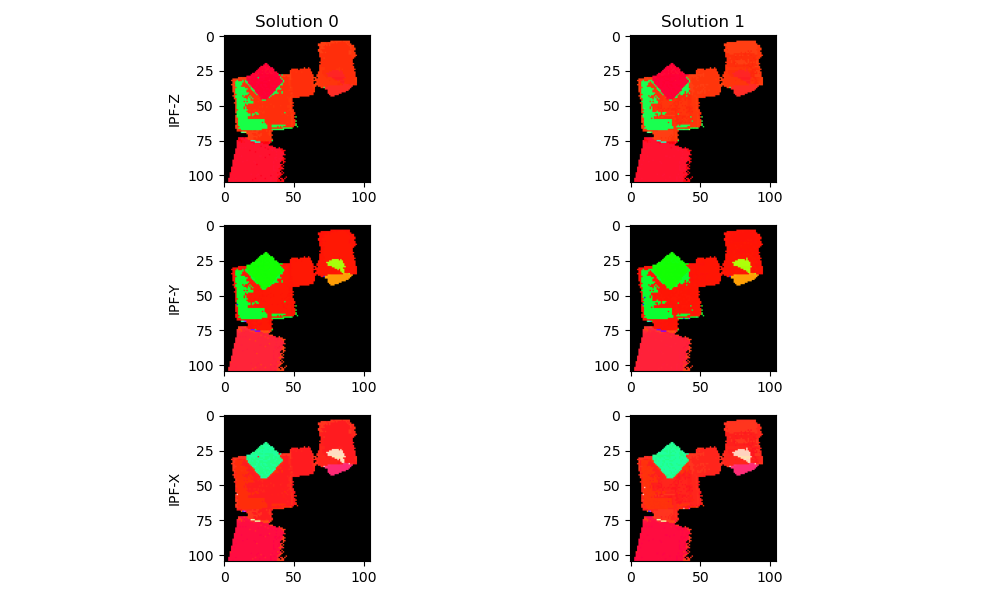

In [33]:
# plotting the orientation maps and the Inverse Pole Figures
solution = result["orientation"]

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from orix.projections import StereographicProjection

# map a vector onto the fundamental zone of the hexagon
def to_fundamental(data_sol):
    data_sol = np.abs(data_sol)
    data_sol = np.sort(data_sol, axis=-1)
    column = data_sol[...,0].copy()
    data_sol[..., 0] = data_sol[...,1]
    data_sol[..., 1] = column
    return data_sol


def get_ipf_color(vectors):
    # the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
    # this matrix maps the beam directions onto the right color vector
    color_corners = np.array([[0, 1, 1],
                              [0, 0, 1],
                              [1, 1, 1]])
    color_mapper = np.linalg.inv(color_corners)
    # a bit of wrangling
    data_sol = to_fundamental(vectors.data)
    flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
    rgb_mapped = np.dot(color_mapper, flattened)
    rgb_mapped = np.abs(rgb_mapped / rgb_mapped.max(axis=0)).T
    rgb_mapped = rgb_mapped.reshape(data_sol.shape)
    return rgb_mapped
    
    
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# draw IPF - Z (row 1), IPF - Y (row 2), IPF - Z (row 3)
fig, ax = plt.subplots(ncols = solution.shape[2], nrows = 3, figsize = (10, 6))

for i in range(solution.shape[2]):
    solution_vectors_z = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.zvector()  
    solution_vectors_y = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.yvector()   
    solution_vectors_x = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.xvector()   
    ax[0, i].set_title(f"Solution {i}")
    ax[0, i].imshow(get_ipf_color(solution_vectors_z)*mask.data[:,:, np.newaxis])
    ax[1, i].imshow(get_ipf_color(solution_vectors_y)*mask.data[:,:, np.newaxis])
    ax[2, i].imshow(get_ipf_color(solution_vectors_x)*mask.data[:,:, np.newaxis])

ax[0,0].set_ylabel("IPF-Z")
ax[1,0].set_ylabel("IPF-Y")
ax[2,0].set_ylabel("IPF-X")

fig.tight_layout()

## Let's Check Our Orientation Mapping Results!

In [34]:
def index2vectors(result, solution=0):
    vectors = np.empty(result["template_index"].shape[:2], dtype=object)
    for i in np.ndindex(result["template_index"].shape[:2]):
        sim_sol_index = result["template_index"][i][solution]
        sim_sol = diff_lib_mgo["MgO"]["simulations"][sim_sol_index]
        in_plane_angle=result["orientation"][i][solution,0]
        result["mirrored_template"][i][solution]
        mirrored=result["mirrored_template"][i][solution]
        x, y = rotate_simulated_pattern(sim_sol, in_plane_angle, mirrored)
        vectors[i]= np.stack([y,x], axis=1)
    return DiffractionVectors(vectors)

def rotate_simulated_pattern(simulation, in_plane_angle, mirrored, center=(0,0)):
    ox = simulation.coordinates[:, 0]
    oy = simulation.coordinates[:, 1]
    if mirrored:
        oy = -oy
    c = np.cos(np.deg2rad(in_plane_angle))
    s = np.sin(np.deg2rad(in_plane_angle))
    # rotate it
    x = c * ox - s * oy + center[0]
    y = s * ox + c * oy + center[1]
    return x,y 

In [35]:
v = index2vectors(result)

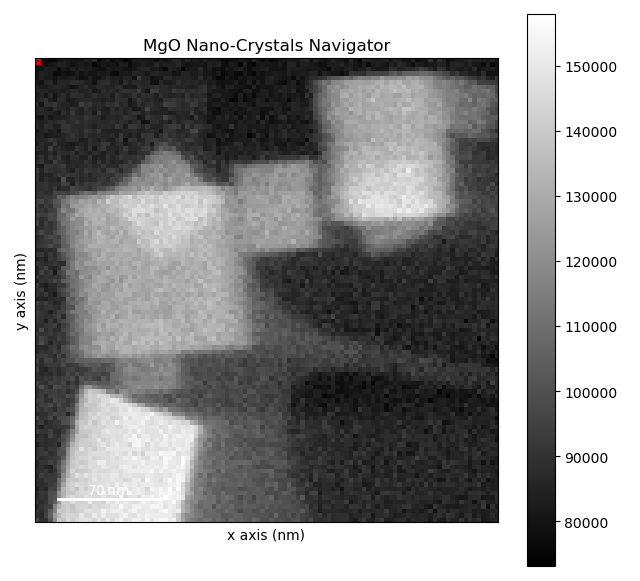

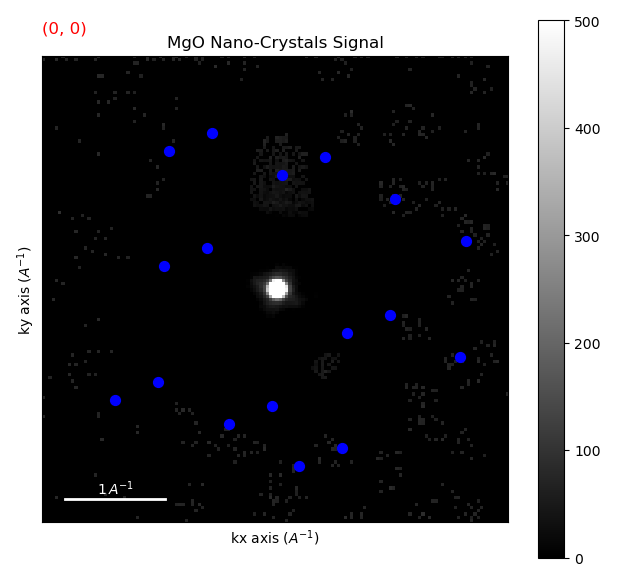

In [36]:
from pyxem.signals.diffraction_vectors import generate_marker_inputs_from_peaks
xx,yy = generate_marker_inputs_from_peaks(v) # generating hyperspy markers from peaks
dp_sub.plot(vmax=500)
for x,y in zip(xx,yy):
    m = hs.plot.markers.point(y,x,
                              color="blue",
                              size=50,)
    dp_sub.add_marker(m, plot_marker=True, permanent=False,)

### 3e.[Strain Mapping (Inclusions in ZrNb)](https://github.com/CSSFrancis/PyxemIUMAS/blob/master/Extras/Strain%20Mapping.ipynb)
<center><img src="Images/Strain Mapping.png" alt="StrainMapping" height="1000" width="1000"></center>

### 3f. [Electrical and Magnetic DPC](https://github.com/pyxem/pyxem-demos)
<center><img src="Images/MagneticDPC.jpg" alt="MagneticDPC" height="1000" width="1000"></center>

### 3g. [Orientation Mapping for Molecular Glasses](https://github.com/CSSFrancis/PyxemIUMAS/blob/master/Extras/12%20MolecularGlassOrientationMapping.ipynb)
<center><img src="Images/MolecularGlassOrientationImage.jpeg" alt="Molc.Glass.Orientation" height="1000" width="1000"></center>

# 4. Lazy Workflows and Scaling to Large Datasets

1. All of the operations you did today were lazy (and out of memory!)
2. This data set (~1GB in size) would have completely run my laptop out of RAM if I didn't run it lazily because of the number of copies/ different views etc.
3. Even plotting is done without loading data into memory!
4. One workflow from desktop to cluster computing!

#### Leaving You with This

- Loading Data from disk and transfer is ___No Lognger Slow___
- We routinely see ~30Gb/sec i-o from spinning disks! 
- That means that we can process a 1 Tb dataset in ~ 1 minute

### Bonus: Creating an Annular Virtual Darkfield Detector for a 5-D STEM (1.8 TB Dataset)

<center><video controls src="Images/LargeDataDemo.mp4" height=500/></center>

## 5. Come Join us!
- Drop by and say hi on github.  Make an [issue](https://github.com/pyxem/pyxem/issues) for a feature you would like, add some code you find helpful. 
- Even if you are just trying something out or need help we are always happy to help!
- Pyxem is not funded by any organization but developed by people who are passionate about sharing their work and writing good code 
- Any and all help is appreciated!